# 拒绝推断
> 使用tensorflow 建立回归模型， 并使用拒绝推断方法对无标签数据打分
## 分配法
此方法是依据每一个分数区间的好坏重新分配好坏客户，并将拒绝件分配到每一个分数区间中，以下是具体步骤：

1） 已知好坏样本，建立初步模型；

2） 使用初步模型对所有被拒绝件进行评分，并预测他们的预期违约率；

3） 将已知的好坏样本依评分分数高低进行分组，计算各分组内实际违约率；

4） 将被拒件依照3）步的分数进行分组，以各分组的实际违约率做为抽样比例，随机抽取该分组下的被拒件，并指定其为坏，其余为好；

5） 将这些推论的有标签的数据新增加到原有的数据集中，重新建模。

In [2]:
import pickle as pkl
import numpy as np
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import multiprocess
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [3]:
train = pd.read_pickle('../data/feature-selected/train.pkl')

In [4]:
eval = pd.read_pickle('../data/feature-selected/eval.pkl')

In [5]:
valid = pd.read_pickle('../data/feature-selected/valid.pkl')
valid['label']=0
valid['tag']=0
valid.head()

,loan_dt,f1,f2,f5,f14,f15,f18,f20,f21,f28,...,f6725,f6728,f6734,f6735,f6737,f6742,f6743,f6745,label,tag
id,,,,,,,,,,,,,,,,,,,,,
100001,2018-03-07,57.0,0.0,442.180084,NaN,5.0000,0,0.024681,1.0,0.033447,...,27.620493,0.200,450.100006,0.000851,20293.0,0,0.0,49.197765,0,0
100002,2018-03-07,0.0,NaN,0.000000,0.000039,5.3333,0,0.000000,NaN,0.000000,...,14.480687,0.000,NaN,0.000000,6638.0,0,0.0,0.000000,0,0
100003,2018-01-27,0.0,NaN,21.197485,NaN,3.5000,0,0.013158,NaN,0.327245,...,11.838667,0.000,3893.979980,0.002193,32251.0,0,0.0,27.341463,0,0
100004,2018-03-29,0.0,NaN,0.000000,NaN,5.2727,0,0.006873,NaN,0.000000,...,24.462925,0.000,NaN,0.004009,36614.0,0,0.0,0.000000,0,0
100005,2018-01-23,0.0,41.0,43.675888,0.000208,23.0000,0,0.096890,99.0,0.007577,...,8.279123,0.125,NaN,0.000000,16384.0,0,0.0,15.253415,0,0


In [6]:
# 数据乱序
def c(data):
    X, y = data
    ind = np.arange(X.shape[0])
    for i in range(7):
        np.random.shuffle(ind)
    return X[ind], y[ind]

In [7]:
# 数据切片
def slice(csr_data, start=0, size=-1):
    if not isinstance(csr_data[0], list):
        if size == -1 or start + size >= csr_data[0].shape[0]:
            slc_data = csr_data[0][start:]
            slc_labels = csr_data[1][start:]
        else:
            slc_data = csr_data[0][start:start + size]
            slc_labels = csr_data[1][start:start + size]
    else:
        if size == -1 or start + size >= csr_data[0][0].shape[0]:
            slc_data = []
            for d_i in csr_data[0]:
                slc_data.append(d_i[start:])
            slc_labels = csr_data[1][start:]
        else:
            slc_data = []
            for d_i in csr_data[0]:
                slc_data.append(d_i[start:start + size])
            slc_labels = csr_data[1][start:start + size]
    return slc_data, slc_labels

In [8]:
# 数据切分
def split_data(data, skip_empty=True):
    fields = []
    for i in range(len(FIELD_OFFSETS) - 1):
        start_ind = FIELD_OFFSETS[i]
        end_ind = FIELD_OFFSETS[i + 1]
        if skip_empty and start_ind == end_ind:
            continue
        field_i = data[0][:, start_ind:end_ind]
        fields.append(field_i)
    fields.append(data[0][:, FIELD_OFFSETS[-1]:])
    return fields, data[1]

In [9]:
# 在tensorflow中初始化各种参数变量
def init_var_map(init_vars, init_path=None):
    if init_path is not None:
        load_var_map = pkl.load(open(init_path, 'rb'))
        print('load variable map from', init_path, load_var_map.keys())
    var_map = {}
    for var_name, var_shape, init_method, dtype in init_vars:
        if init_method == 'zero':
            var_map[var_name] = tf.Variable(tf.zeros(var_shape, dtype=dtype), name=var_name, dtype=dtype)
        elif init_method == 'one':
            var_map[var_name] = tf.Variable(tf.ones(var_shape, dtype=dtype), name=var_name, dtype=dtype)
        elif init_method == 'normal':
            var_map[var_name] = tf.Variable(tf.random_normal(var_shape, mean=0.0, stddev=STDDEV, dtype=dtype),
                                            name=var_name, dtype=dtype)
        elif init_method == 'tnormal':
            var_map[var_name] = tf.Variable(tf.truncated_normal(var_shape, mean=0.0, stddev=STDDEV, dtype=dtype),
                                            name=var_name, dtype=dtype)
        elif init_method == 'uniform':
            var_map[var_name] = tf.Variable(tf.random_uniform(var_shape, minval=MINVAL, maxval=MAXVAL, dtype=dtype),
                                            name=var_name, dtype=dtype)
        elif init_method == 'xavier':
            maxval = np.sqrt(6. / np.sum(var_shape))
            minval = -maxval
            var_map[var_name] = tf.Variable(tf.random_uniform(var_shape, minval=minval, maxval=maxval, dtype=dtype),
                                            name=var_name, dtype=dtype)
        elif isinstance(init_method, int) or isinstance(init_method, float):
            var_map[var_name] = tf.Variable(tf.ones(var_shape, dtype=dtype) * init_method, name=var_name, dtype=dtype)
        elif init_method in load_var_map:
            if load_var_map[init_method].shape == tuple(var_shape):
                var_map[var_name] = tf.Variable(load_var_map[init_method], name=var_name, dtype=dtype)
            else:
                print('BadParam: init method', init_method, 'shape', var_shape, load_var_map[init_method].shape)
        else:
            print('BadParam: init method', init_method)
    return var_map

In [10]:
# 不同的激活函数选择
def activate(weights, activation_function):
    if activation_function == 'sigmoid':
        return tf.nn.sigmoid(weights)
    elif activation_function == 'softmax':
        return tf.nn.softmax(weights)
    elif activation_function == 'relu':
        return tf.nn.relu(weights)
    elif activation_function == 'tanh':
        return tf.nn.tanh(weights)
    elif activation_function == 'elu':
        return tf.nn.elu(weights)
    elif activation_function == 'none':
        return weights
    else:
        return weights

In [11]:
# 不同的优化器选择
def get_optimizer(opt_algo, learning_rate, loss):
    if opt_algo == 'adaldeta':
        return tf.train.AdadeltaOptimizer(learning_rate).minimize(loss)
    elif opt_algo == 'adagrad':
        return tf.train.AdagradOptimizer(learning_rate).minimize(loss)
    elif opt_algo == 'adam':
        return tf.train.AdamOptimizer(learning_rate).minimize(loss)
    elif opt_algo == 'ftrl':
        return tf.train.FtrlOptimizer(learning_rate).minimize(loss)
    elif opt_algo == 'gd':
        return tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    elif opt_algo == 'padagrad':
        return tf.train.ProximalAdagradOptimizer(learning_rate).minimize(loss)
    elif opt_algo == 'pgd':
        return tf.train.ProximalGradientDescentOptimizer(learning_rate).minimize(loss)
    elif opt_algo == 'rmsprop':
        return tf.train.RMSPropOptimizer(learning_rate).minimize(loss)
    else:
        return tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [12]:
# 工具函数
# 提示：tf.slice(input_, begin, size, name=None)：按照指定的下标范围抽取连续区域的子集
#   tf.gather(params, indices, validate_indices=None, name=None)：按照指定的下标集合从axis=0中抽取子集，适合抽取不连续区域的子集
def gather_2d(params, indices):
    shape = tf.shape(params)
    flat = tf.reshape(params, [-1])
    flat_idx = indices[:, 0] * shape[1] + indices[:, 1]
    flat_idx = tf.reshape(flat_idx, [-1])
    return tf.gather(flat, flat_idx)

In [13]:
# 池化2d
def max_pool_2d(params, k):
    _, indices = tf.nn.top_k(params, k, sorted=False)
    shape = tf.shape(indices)
    r1 = tf.reshape(tf.range(shape[0]), [-1, 1])
    r1 = tf.tile(r1, [1, k])
    r1 = tf.reshape(r1, [-1, 1])
    indices = tf.concat([r1, tf.reshape(indices, [-1, 1])], 1)
    return tf.reshape(gather_2d(params, indices), [-1, k])

In [14]:
# 定义基类模型
dtype = tf.float32
STDDEV = 1e-3
MINVAL = -1e-3
MAXVAL = 1e-3
class Model:
    def __init__(self):
        self.sess = None
        self.X = None
        self.y = None
        self.layer_keeps = None
        self.vars = None
        self.keep_prob_train = None
        self.keep_prob_test = None

    # run model
    def run(self, fetches, X=None, y=None, mode='train'):
            # 通过feed_dict传入数据
            feed_dict = {}
            if type(self.X) is list:
                for i in range(len(X)):
                    feed_dict[self.X[i]] = X[i]
            else:
                feed_dict[self.X] = X
            if y is not None:
                feed_dict[self.y] = y
            if self.layer_keeps is not None:
                if mode == 'train':
                    feed_dict[self.layer_keeps] = self.keep_prob_train
                elif mode == 'test':
                    feed_dict[self.layer_keeps] = self.keep_prob_test
            #通过session.run去执行op
            return self.sess.run(fetches, feed_dict)      
        
    # 模型参数持久化
    def dump(self, model_path):
        var_map = {}
        for name, var in self.vars.iteritems():
            var_map[name] = self.run(var)
        pkl.dump(var_map, open(model_path, 'wb'))
        print('model dumped at', model_path)

### 1.LR逻辑回归
![](https://pic3.zhimg.com/80/v2-09c0c9a25fa46886f92404fef41bbb82_hd.jpg)
输入输出:{X,y}<br>
映射函数f(x)：单层单节点的“DNN”, 宽而不深，sigmoid(wx+b)输出概率，需要大量的人工特征工程，非线性来源于特征处理<br>
损失函数：logloss/... + L1/L2/...<br>
优化方法：sgd/...<br>
评估：logloss/auc/...<br>

In [15]:
class LR(Model):
    def __init__(self, input_dim=None, output_dim=1, init_path=None, opt_algo='gd', learning_rate=1e-2, l2_weight=0,
                 random_seed=None):
        Model.__init__(self)
        # 声明参数
        init_vars = [('w', [input_dim, output_dim], 'xavier', dtype),
                     ('b', [output_dim], 'zero', dtype)]
        self.graph = tf.Graph()
        with self.graph.as_default():
            if random_seed is not None:
                tf.set_random_seed(random_seed)
            # 用稀疏的placeholder
            self.X = tf.placeholder(dtype)
            self.y = tf.placeholder(dtype)
            # init参数
            self.vars = init_var_map(init_vars, init_path)

            w = self.vars['w']
            b = self.vars['b']
            # sigmoid(wx+b)
            xw = tf.matmul(self.X, w)
            logits = tf.reshape(xw + b, [-1])
            self.y_prob = tf.sigmoid(logits)

            self.loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(labels=self.y, logits=logits)) + \
                        l2_weight * tf.nn.l2_loss(xw)
            self.optimizer = get_optimizer(opt_algo, learning_rate, self.loss)
            # GPU设定
            config = tf.ConfigProto()
            config.gpu_options.allow_growth = True
            self.sess = tf.Session(config=config)
            # 初始化图里的参数
            tf.global_variables_initializer().run(session=self.sess)

In [20]:
# 对数值型特征，normalize处理
from sklearn.preprocessing  import MinMaxScaler
from sklearn.preprocessing.imputation import Imputer
from sklearn.pipeline import make_pipeline

train = train.fillna(0)
tdata = train.drop(['label', 'tag', 'loan_dt'],axis=1)
scaler = MinMaxScaler()
scaler.fit(tdata)

def read_data(data):
    X= data.drop(['label', 'tag', 'loan_dt'],axis=1)
    X = X.fillna(0)
    y = data.label
    X= scaler.transform(X)
    return X,y

In [21]:
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
import progressbar
import time

t, v = train_test_split(train, test_size=0.33)

train_data = read_data(t)
test_data = read_data(v)
eval_data = read_data(eval)
valid_data = read_data(valid)

input_dim = train_data[0].shape[1]


# 输出数据信息维度
if train_data[1].ndim > 1:
    print('label must be 1-dim')
    exit(0)
print('read finish')
print('train data size:', train_data[0].shape)
print('test data size:', test_data[0].shape)

# 训练集与测试集
train_size = train_data[0].shape[0]
test_size = test_data[0].shape[0]

# 超参数设定
min_round = 1
num_round = 50
early_stop_round = 5
# train + val
batch_size = 512


# 逻辑回归参数设定
lr_params = {
    'input_dim': input_dim,
    'opt_algo': 'rmsprop',
    'learning_rate': 0.001,
    'l2_weight': 1e-5,
    'random_seed': 0
}
print(lr_params)
model = LR(**lr_params)
print("training LR...")
def train_model(model):
    history_score = []
    saver = tf.train.Saver(model.vars)
    # 执行num_round轮
    for i in range(num_round):
        t1= time.time()
        # 主要的2个op是优化器和损失
        fetches = [model.optimizer, model.loss]
        if batch_size > 0:
            ls = []
            # 进度条工具
            bar = progressbar.ProgressBar()
            print('[%d]\ttraining...' % i)
            for j in bar(range(int(train_size / batch_size + 1))):
                X_i, y_i = slice(train_data, j * batch_size, batch_size)
                # 训练，run op
                _, l = model.run(fetches, X_i, y_i)
                ls.append(l)
        elif batch_size == -1:
            X_i, y_i = slice(train_data)
            _, l = model.run(fetches, X_i, y_i)
            ls = [l]
        train_preds = []
        print('[%d]\tevaluating...' % i)
        bar = progressbar.ProgressBar()
        for j in bar(range(int(train_size / 10000 + 1))):
            X_i, _ = slice(train_data, j * 10000, 10000)
            preds = model.run(model.y_prob, X_i, mode='test')
            train_preds.extend(preds)
        test_preds = []
        bar = progressbar.ProgressBar()
        for j in bar(range(int(test_size / 10000 + 1))):
            X_i, _ = slice(test_data, j * 10000, 10000)
            preds = model.run(model.y_prob, X_i, mode='test')
            test_preds.extend(preds)
        # 把预估的结果和真实结果拿出来计算auc
        train_score = roc_auc_score(train_data[1], train_preds)
        train_acc = accuracy_score(train_data[1], np.array(train_preds)>0.4)
        test_score = roc_auc_score(test_data[1], test_preds)
        test_acc = accuracy_score(test_data[1], np.array(test_preds)>0.4)
        # 输出auc信息
        print('[%d]%.2fs\tloss (with l2 norm):%f\ttrain-auc: %f\teval-auc: %f\ttrain-acc:%f\teval-acc:%f' % (
            i,time.time()-t1, np.mean(ls), train_score, test_score,train_acc, test_acc))
        history_score.append(test_score)
        # early stopping
        if i > min_round and i > early_stop_round:
            if np.argmax(history_score) == i - early_stop_round and history_score[-1] - history_score[
                        -1 * early_stop_round] < 1e-5:
                print('early stop\nbest iteration:\n[%d]\teval-auc: %f' % (
                    np.argmax(history_score), np.max(history_score)))
                break
    save_path = saver.save(model.sess, "./tmp/model.ckpt")
    print("Model saved in path: %s" % save_path)
    
train_model(model)

read finish
train data size: (22420, 2937)
test data size: (11044, 2937)
{'random_seed': 0, 'l2_weight': 1e-05, 'input_dim': 2937, 'learning_rate': 0.001, 'opt_algo': 'rmsprop'}


training LR...
[0]	training...


100% |########################################################################|


[0]	evaluating...


100% |########################################################################|
100% |########################################################################|


[0]6.99s	loss (with l2 norm):0.371433	train-auc: 0.441085	eval-auc: 0.435063	train-acc:0.935772	eval-acc:0.931365
[1]	training...


100% |########################################################################|


[1]	evaluating...


100% |########################################################################|
100% |########################################################################|


[1]5.95s	loss (with l2 norm):0.260457	train-auc: 0.544154	eval-auc: 0.544105	train-acc:0.935772	eval-acc:0.931365
[2]	training...


100% |########################################################################|


[2]	evaluating...


100% |########################################################################|
100% |########################################################################|


[2]6.25s	loss (with l2 norm):0.248680	train-auc: 0.739546	eval-auc: 0.740447	train-acc:0.935772	eval-acc:0.931365
[3]	training...


100% |########################################################################|


[3]	evaluating...


100% |########################################################################|
100% |########################################################################|


[3]5.80s	loss (with l2 norm):0.236821	train-auc: 0.778757	eval-auc: 0.779069	train-acc:0.935638	eval-acc:0.931275
[4]	training...


100% |########################################################################|


[4]	evaluating...


100% |########################################################################|
100% |########################################################################|


[4]6.03s	loss (with l2 norm):0.230248	train-auc: 0.794622	eval-auc: 0.792996	train-acc:0.935861	eval-acc:0.931184
[5]	training...


100% |########################################################################|


[5]	evaluating...


100% |########################################################################|
100% |########################################################################|


[5]6.12s	loss (with l2 norm):0.226382	train-auc: 0.804760	eval-auc: 0.800753	train-acc:0.936039	eval-acc:0.931184
[6]	training...


100% |########################################################################|


[6]	evaluating...


100% |########################################################################|
100% |########################################################################|


[6]6.10s	loss (with l2 norm):0.223634	train-auc: 0.812299	eval-auc: 0.805757	train-acc:0.936039	eval-acc:0.931547
[7]	training...


100% |########################################################################|


[7]	evaluating...


100% |########################################################################|
100% |########################################################################|


[7]5.92s	loss (with l2 norm):0.221434	train-auc: 0.818312	eval-auc: 0.809304	train-acc:0.936530	eval-acc:0.931547
[8]	training...


100% |########################################################################|


[8]	evaluating...


100% |########################################################################|
100% |########################################################################|


[8]5.74s	loss (with l2 norm):0.219555	train-auc: 0.823319	eval-auc: 0.811930	train-acc:0.936798	eval-acc:0.931728
[9]	training...


100% |########################################################################|


[9]	evaluating...


100% |########################################################################|
100% |########################################################################|


[9]5.98s	loss (with l2 norm):0.217886	train-auc: 0.827595	eval-auc: 0.814001	train-acc:0.936976	eval-acc:0.931637
[10]	training...


100% |########################################################################|


[10]	evaluating...


100% |########################################################################|
100% |########################################################################|


[10]5.93s	loss (with l2 norm):0.216371	train-auc: 0.831273	eval-auc: 0.815619	train-acc:0.937333	eval-acc:0.931909
[11]	training...


100% |########################################################################|


[11]	evaluating...


100% |########################################################################|
100% |########################################################################|


[11]5.05s	loss (with l2 norm):0.214975	train-auc: 0.834577	eval-auc: 0.816919	train-acc:0.937511	eval-acc:0.932180
[12]	training...


100% |########################################################################|


[12]	evaluating...


100% |########################################################################|
100% |########################################################################|


[12]6.13s	loss (with l2 norm):0.213673	train-auc: 0.837502	eval-auc: 0.817930	train-acc:0.937690	eval-acc:0.931909
[13]	training...


100% |########################################################################|


[13]	evaluating...


100% |########################################################################|
100% |########################################################################|


[13]6.01s	loss (with l2 norm):0.212452	train-auc: 0.840142	eval-auc: 0.818788	train-acc:0.937823	eval-acc:0.931909
[14]	training...


100% |########################################################################|


[14]	evaluating...


100% |########################################################################|
100% |########################################################################|


[14]6.30s	loss (with l2 norm):0.211298	train-auc: 0.842541	eval-auc: 0.819433	train-acc:0.938180	eval-acc:0.931909
[15]	training...


100% |########################################################################|


[15]	evaluating...


100% |########################################################################|
100% |########################################################################|


[15]5.93s	loss (with l2 norm):0.210203	train-auc: 0.844725	eval-auc: 0.820002	train-acc:0.938492	eval-acc:0.932271
[16]	training...


100% |########################################################################|


[16]	evaluating...


100% |########################################################################|
100% |########################################################################|


[16]6.08s	loss (with l2 norm):0.209159	train-auc: 0.846719	eval-auc: 0.820463	train-acc:0.938448	eval-acc:0.932271
[17]	training...


100% |########################################################################|


[17]	evaluating...


100% |########################################################################|
100% |########################################################################|


[17]5.50s	loss (with l2 norm):0.208162	train-auc: 0.848562	eval-auc: 0.820801	train-acc:0.938537	eval-acc:0.932452
[18]	training...


100% |########################################################################|


[18]	evaluating...


100% |########################################################################|
100% |########################################################################|


[18]6.25s	loss (with l2 norm):0.207206	train-auc: 0.850282	eval-auc: 0.821069	train-acc:0.938715	eval-acc:0.932543
[19]	training...


100% |########################################################################|


[19]	evaluating...


100% |########################################################################|
100% |########################################################################|


[19]5.36s	loss (with l2 norm):0.206287	train-auc: 0.851885	eval-auc: 0.821308	train-acc:0.938760	eval-acc:0.932452
[20]	training...


100% |########################################################################|


[20]	evaluating...


100% |########################################################################|
100% |########################################################################|


[20]6.47s	loss (with l2 norm):0.205401	train-auc: 0.853375	eval-auc: 0.821460	train-acc:0.938938	eval-acc:0.932361
[21]	training...


100% |########################################################################|


[21]	evaluating...


100% |########################################################################|
100% |########################################################################|


[21]5.78s	loss (with l2 norm):0.204547	train-auc: 0.854771	eval-auc: 0.821584	train-acc:0.938805	eval-acc:0.931818
[22]	training...


100% |########################################################################|


[22]	evaluating...


100% |########################################################################|
100% |########################################################################|


[22]6.15s	loss (with l2 norm):0.203721	train-auc: 0.856069	eval-auc: 0.821651	train-acc:0.938938	eval-acc:0.931728
[23]	training...


100% |########################################################################|


[23]	evaluating...


100% |########################################################################|
100% |########################################################################|


[23]5.45s	loss (with l2 norm):0.202921	train-auc: 0.857315	eval-auc: 0.821673	train-acc:0.939028	eval-acc:0.931999
[24]	training...


100% |########################################################################|


[24]	evaluating...


100% |########################################################################|
100% |########################################################################|


[24]5.56s	loss (with l2 norm):0.202146	train-auc: 0.858494	eval-auc: 0.821653	train-acc:0.938983	eval-acc:0.932180
[25]	training...


100% |########################################################################|


[25]	evaluating...


100% |########################################################################|
100% |########################################################################|


[25]6.58s	loss (with l2 norm):0.201394	train-auc: 0.859599	eval-auc: 0.821624	train-acc:0.939072	eval-acc:0.932271
[26]	training...


100% |########################################################################|


[26]	evaluating...


100% |########################################################################|
100% |########################################################################|


[26]5.40s	loss (with l2 norm):0.200663	train-auc: 0.860653	eval-auc: 0.821602	train-acc:0.939028	eval-acc:0.932452
[27]	training...


100% |########################################################################|


[27]	evaluating...


100% |########################################################################|
100% |########################################################################|


[27]6.23s	loss (with l2 norm):0.199952	train-auc: 0.861645	eval-auc: 0.821581	train-acc:0.939161	eval-acc:0.932271
[28]	training...


100% |########################################################################|


[28]	evaluating...


100% |########################################################################|
100% |########################################################################|


[28]6.06s	loss (with l2 norm):0.199260	train-auc: 0.862598	eval-auc: 0.821490	train-acc:0.939206	eval-acc:0.931999
early stop
best iteration:
[23]	eval-auc: 0.821673
Model saved in path: ./tmp/model.ckpt


拒绝推断

In [22]:
X_i, y_i = slice(train_data)
train_preds = model.run(model.y_prob, X_i, mode='test')
train_preds

array([0.05522371, 0.03395312, 0.05165528, ..., 0.18755345, 0.0676312 ,
       0.08775756], dtype=float32)

In [23]:
X_i, y_i = slice(test_data)
test_preds = model.run(model.y_prob, X_i, mode='test')
test_preds

array([0.05667618, 0.03158789, 0.0318908 , ..., 0.07484034, 0.10511034,
       0.00389753], dtype=float32)

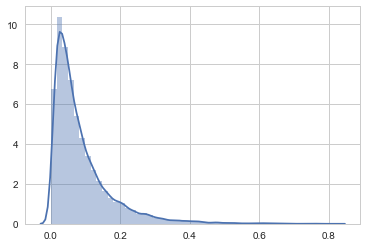

In [24]:
%matplotlib inline
sns.distplot(test_preds, rug=False);

In [25]:
valid_preds = np.array(test_preds)
pred_overdue_rate = np.mean(test_preds>=0.4)
actual_overdue_rate = test_data[1].mean()
print('predicted overdue rate:%f'%pred_overdue_rate)
print('actual overdue rate: %f' % actual_overdue_rate)

predicted overdue rate:0.013310
actual overdue rate: 0.068635


In [26]:
test_data[1].mean()

0.06863455474376678